In [1]:
!pip install shap

     |████████████████████████████████| 273 kB 3.6 MB/s eta 0:00:01
  Created wheel for shap: filename=shap-0.35.0-cp37-cp37m-linux_x86_64.whl size=399280 sha256=569834151c5c7cb4f0268b594d1b15121d1b391e6b1eb6956dac082296f321da
  Stored in directory: /home/jovyan/.cache/pip/wheels/c3/e0/82/26cebc699e23c6a1b9963981e1a10ed7de75db012f4af12428
Successfully built shap


# Sentiment Analysis with Logistic Regression

This gives a simple example of explaining a linear logistic regression sentiment analysis model using shap. Note that with a linear model the SHAP value for feature i for the prediction $f(x)$ (assuming feature independence) is just $\phi_i = \beta_i \cdot (x_i - E[x_i])$. Since we are explaining a logistic regression model the units of the SHAP values will be in the log-odds space.

The dataset we use is the classic IMDB dataset from [this paper](http://www.aclweb.org/anthology/P11-1015). It is interesting when explaining the model how the words that are absent from the text are sometimes just as important as those that are present.

In [2]:
import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import shap

shap.initjs()

## Load the IMDB dataset

In [3]:
corpus,y = shap.datasets.imdb()
corpus_train, corpus_test, y_train, y_test = train_test_split(corpus, y, test_size=0.2, random_state=7)

vectorizer = TfidfVectorizer(min_df=10)
X_train = vectorizer.fit_transform(corpus_train)
X_test = vectorizer.transform(corpus_test)

## Fit a linear logistic regression model

In [5]:
model = sklearn.linear_model.LogisticRegression(penalty="l2", C=0.1)
model.fit(X_train, y_train)

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

## Explain the linear model

In [6]:
explainer = shap.LinearExplainer(model, X_train, feature_dependence="independent")
shap_values = explainer.shap_values(X_test)
X_test_array = X_test.toarray() # we need to pass a dense version for the plotting functions

The option feature_dependence has been renamed to feature_perturbation!
The option feature_perturbation="independent" is has been renamed to feature_perturbation="interventional"!


### Summarize the effect of all the features

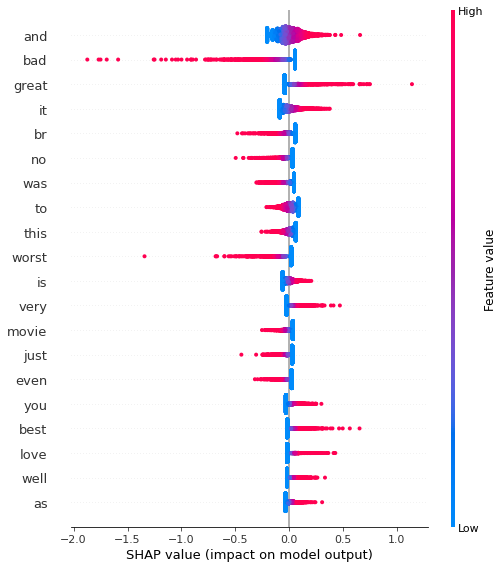

In [7]:
shap.summary_plot(shap_values, X_test_array, feature_names=vectorizer.get_feature_names())

### Explain the first review's sentiment prediction

Remember that higher means more likely to be negative, so in the plots below the "red" features are actually helping raise the chance of a positive review, while the negative features are lowering the chance. It is interesting to see how what is not present in the text (like bad=0 below) is often just as important as what is in the text. Remember the values of the features are TF-IDF values.

In [8]:
ind = 0
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

In [9]:
print("Positive" if y_test[ind] else "Negative", "Review:")
print(corpus_test[ind])

Positive Review:
"Twelve Monkeys" is odd and disturbing, yet being so clever and intelligent at the same time. It cleverly jumps between future and the past, and the story it tells is about a man named James Cole, a convict, who is sent back to the past to gather information about a man-made virus that wiped out 5 billion of the human population on the planet back in 1996. At first Cole is sent back to the year 1990 by accident and by misfortune he is taken to a mental institution where he tries to explain his purpose and where he meets a psychiatrist Dr. Kathryn Railly who tries to help him and a patient named Jeffrey Goines, the insane son of a famous scientist. Being provocative and somehow so sensible, dealing with and between reason and madness, the movie is a definite masterpiece in the history of science-fiction films.<br /><br />The story is just fantastic. It's so original and so entertaining. The screenplay itself written by David and Janet Peoples is inspired by a movie name

### Explain the second review's sentiment prediction

In [10]:
ind = 1
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

In [11]:
print("Positive" if y_test[ind] else "Negative", "Review:")
print(corpus_test[ind])

Negative Review:
I don't understand the positive comments made about this film. It is cheap and nasty on all levels and I cannot understand how it ever got made.<br /><br />Cartoon characters abound - Sue's foul-mouthed, alcoholic, layabout, Irish father being a prime example. None of the characters are remotely sympathetic - except, briefly, for Sue's Asian boyfriend but even he then turns out to be capable of domestic violence! As desperately unattractive as they both are, I've no idea why either Rita and/or Sue would throw themselves at a consummate creep like Bob - but given that they do, why should I be expected to care what happens to them? So many reviews keep carping on about how "realistic" it is. If that is true, it is a sad reflection on society but no reason to put it on film.<br /><br />I didn't like the film at all.



### Explain the third review's sentiment prediction

In [12]:
ind = 2
shap.force_plot(
    explainer.expected_value, shap_values[ind,:], X_test_array[ind,:],
    feature_names=vectorizer.get_feature_names()
)

In [13]:
print("Positive" if y_test[ind] else "Negative", "Review:")
print(corpus_test[ind])

Positive Review:
I finally saw this film tonight after renting it at Blockbuster (VHS). I have to agree that it is wildly original. Yes, maybe the characters were not fully realized but it isn't one of those movies. Rather, we are treated to the director's eye, his vision of what the story is about. And it does not stop. And to be honest, I didn't want it to. I do believe that Sabu had to have influenced the director's of 'Lock, Stock & Two Smoking Barrels' and 'Run, Lola, Run'. But I absolutely loved the way the three leads SEE the beautiful woman on the street to distract them momentarily. I really need to see this director's other work because this film really intrigued me. If you want insight, culture, sturm und drang, go somewhere else. If you want a laugh, camera movement and criminal hilarity, look here.

